<a href="https://colab.research.google.com/github/esdu/probprog_notes/blob/master/BiasedCoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Infer the probability of heads of a biased coin, with TF2

A toy inference problem to make sure we have TFP + TF2 running properly.

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
ACTUAL_PROB = 0.2
N_OBS = 10000

In [0]:
#%env AUTOGRAPH_VERBOSITY=10 # turn this on to debug autograph warnings

In [0]:
!pip install tensorflow-probability==0.8 # 0.8 is 2x faster than 0.7 for this problem!
#!pip install gast==0.2.2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp

In [0]:
tf.__version__

'2.0.0'

In [0]:
tfp.__version__

'0.8.0'

We write this out to a file so @tf.function can find its source code (you can also run it in the notebook, it'll just throw a warning)

In [0]:
%%writefile inference.py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

def joint_log_prob(prob, obs):
    rv_prob = tfd.Beta(1,1) # flat prior
    rv_observations = tfd.Bernoulli(probs=prob, dtype=tf.int32)
    return rv_prob.log_prob(prob) + tf.reduce_sum(rv_observations.log_prob(obs))

@tf.function
def graph_mcmc(observations):
  def unnormalized_log_posterior(prob):
    return joint_log_prob(prob, observations)

  # Set the chain's start state.
  initial_chain_state = [
      0.5 * tf.ones([], dtype=tf.float32, name="init_prob"),
  ]

  num_results = 5000
  num_burnin_steps = 500
  kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_log_posterior,
      num_leapfrog_steps=2,
      step_size=0.05)
  kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

  def trace_fn_(_, pkr):
    #return [
    #  pkr.inner_results.accepted_results.step_size,
    #  pkr.inner_results.log_accept_ratio
    #  pkr.inner_results.is_accepted
    #]
    return pkr
  
  # Sample from the chain.
  [
      prob_samples,
  ], kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_chain_state,
      kernel=kernel,
      trace_fn=trace_fn_)
  
  # Note: It's ~18% faster to set trace_fn=None.

  return prob_samples, kernel_results

Overwriting inference.py


In [0]:
%%time

from inference import graph_mcmc

# Simulate data
observations = tfp.distributions.Bernoulli(probs=ACTUAL_PROB, dtype=tf.int32).sample(N_OBS)

# Infer \hat{prob}
prob_samples, kernel_results = graph_mcmc(observations)

CPU times: user 6.66 s, sys: 205 ms, total: 6.87 s
Wall time: 4.65 s


In [0]:
kernel_results.inner_results.is_accepted.numpy().mean()

0.7974

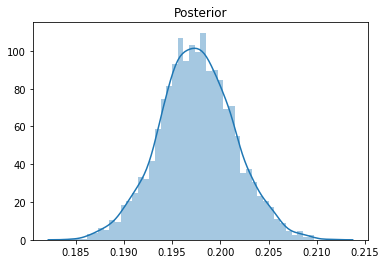

In [0]:
sns.distplot(prob_samples); plt.title("Posterior");